# Recurrent Neural Networks (RNN)

It is time to break out of the confinement of the feed-forward neural networks studied up to now. It's time to move on to recurrent neural networks (RNN's). Please note that [Chris Olah, Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is compulsory reading!

The problem with feed-forward networks is that they cannot naturally handle *dynamic* systems, such as time series. They require a fixed-length input vector, and after a fixed number of steps, produce a fixed-size output. In contrast, RNN's allow us to operate on sequences of vectors and it is not hard to find important applications for this idea. 

In finance, we observe the markets in all their volatility and want to predict the future, taking the history into account.

In natural language processing, one may want to translate a sentence in one language to another language. In this case the input is a sequence of words in one language, and the output is another sequence of words, the translated text. 

There is something magic about RNN's. [Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) talks about the 'Unreasonable effectiveness of Recurrent Neural Networks', and says the following, "I’m training RNNs all the time and I’ve witnessed their power and robustness many times, and yet their magical outputs still find ways of amusing me". 

----
## A Very Simple RNN

<figure> 
<figcaption>**The simplest possible rnn**</figcaption>
<img src="./images/rnn_1.png"
     width=700px
     alt="Simple rnn"
     style="float: center"/> 
</figure>

The Figure above shows the simplest possible RNN. At each time step $t$, the neuron receives two inputs, the observation vector $\mathbf{x}_t$, and its state from the previous timestep, $\mathbf{h}_{t-1}$. The (hidden) state $\mathbf{h}_t$ is output at each step. (Note that the output $\mathbf{h}_t$ is available for further processing if required.) In the right-most image on the left, the RNN is unrolled over time. 

The actual computation for this simple RNN should look familiar,
$$
\mathbf{h}_t = \phi(W_x\mathbf{x}_t + W_h \mathbf{h}_{t-1} + \mathbf{b}),
$$ 
where $\phi$ is the activation function. Each recurrent neuron has two sets of weights shared over all time steps, $W_x$ and $W_h$. If the dimension of the input vector $\mathbf{x}$ is $d$, and that of the output vector $\mathbf{h}$ is $n$, then $W_h$ is an $n\times n$, and $W_x$ a $d\times n$ matrix. The activation function $\phi$ is applied pointwise as before.

We can combine the two weight matrices into one and write
$$
\mathbf{h}_t = \phi(W[\mathbf{x}_t, \mathbf{h}_{t-1}] + \mathbf{b}).
$$



### Note:

* Since $\mathbf{h}_t$ depends on $\mathbf{h}_{t-1}$ and $\mathbf{x}_t$, which depends on $\mathbf{h}_{t-2}$ and $\mathbf{x}_{t-1}$, and so on, $\mathbf{h}_t$ depends on all the time inputs right up to the beginning.
* A part of a network that preserves some part of its state over time steps, is called a *memory cell* or just a *cell*. 
* In general the (hidden) state of a cell $\mathbf{h}_t$ is a function of its state at the previous time step $\mathbf{h}_{t-1}$, and an input at the current time step $\mathbf{x}_t$, i.e. $\mathbf{h}_t = f(\mathbf{h}_{t-1},\mathbf{x}_t)$. 

----
## The Different Structures of an RNN

The next Figure is taken from [Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and illustrates 
the different forms that RNN's can acquire. 

<br>
    
<figure> 
<figcaption>**The different structures of an rnn**</figcaption>
<img src="./images/rnn_2.png"
     width=700px
     alt="Simple rnn"
     style="float: center"/> 
</figure>


## Examples:

To start with we look at a one to one RNN. It really just included here for the sake of completeness but you may as well use a feed forward network. 

A one to many network may be an example of music generation where we provide a single note as an input and the model generates the rest of the song, as multiple outputs. 

A many to one network may be used in predicting the direction of a next day move in alpha design strategies. Here the model is fed a sequence of time series data and outputs the next days direction. 

Last we get to the the many to many network. This is generally split into two. The first may be a sequence to sequence model such as machine translation, say English to French. The other may be a multi class labeling model where we provide a video to the model and we require it to label each frame. 

1. One to one: It really just included here for the sake of completeness but you may as well use a feed forward network.
2. One to many: music generation where we provide a single note as an input and the model generates the rest of the song, as multiple outputs
3. Many to one: used in predicting the direction of a next day move in alpha design strategies. Here the model is fed a sequence of time series data and outputs the next days direction. 
4. Many to many: This is generally split into two. The first may be a sequence to sequence model such as machine translation, say English to French. The other may be a multi class labeling model where we provide a video to the model and we require it to label each frame. 

---

# A Basic RNN in TensorFlow:

Here we essentially follow the open source notebook of [Aurelien Geron, Chapter 14](https://github.com/ageron/handson-ml) and write a basic RNN in TensorFlow. Note how easy it is if we make use of the powerful functions in TensorFlow.

### Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm

%matplotlib inline

# To plot pretty figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Save and Output Settings
Below we setup some global vars that will allow the output to be stable accross runs, as well as where to save images.

In [2]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### Create a Time Series

Next we generate a time series using the following formula: $ \frac{t \sin(t)}{3} + 2 \sin(5t) $

#### Functions

In [3]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    # Create a time series.
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    """
    Generate consecutive samples of time series from the time series. 
    The starting position of the samples is arbitrary.
    
    Parameters
    ----------
    batch_size: int
                The number of series in the batch
    n_steps: int
            The number of samples from the time series in each batch
            
    Return
    ------
    X_batch: (batch_size, n_steps, 1) array
             batch_size samples each of length n_steps, and each sample is 1d
    y_batch: (batch_size, n_steps, 1) array
             targets, shifted one position from X_batch  
    """
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

#### Create Series

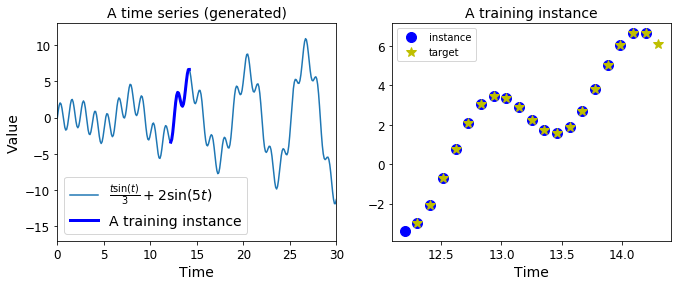

In [4]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

# Plot full series
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$\frac{t\sin(t)}{3} + 2 \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

# Plot training instance
plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [5]:
# Generate a single training instance
X_batch, y_batch = next_batch(1, n_steps)

In [6]:
# Each value in the sequence predicts the next value in the sequence.
np.c_[X_batch[0], y_batch[0]]

array([[ 1.15352294,  2.00049277],
       [ 2.00049277,  2.46949091],
       [ 2.46949091,  2.45385795],
       [ 2.45385795,  1.96445306],
       [ 1.96445306,  1.12676875],
       [ 1.12676875,  0.14999406],
       [ 0.14999406, -0.724396  ],
       [-0.724396  , -1.28193394],
       [-1.28193394, -1.38781614],
       [-1.38781614, -1.02002678],
       [-1.02002678, -0.27481718],
       [-0.27481718,  0.65680343],
       [ 0.65680343,  1.5358113 ],
       [ 1.5358113 ,  2.13370285],
       [ 2.13370285,  2.28849002],
       [ 2.28849002,  1.94444692],
       [ 1.94444692,  1.16587652],
       [ 1.16587652,  0.12152578],
       [ 0.12152578, -0.95653592],
       [-0.95653592, -1.82950897]])

---
# Basic RNN

Now that we have generated the series, lets continue to build a model that will be useful in predicting the series. 

## Construction
We are all familiar with the construction and execution steps. For the basic RNN we use tf.contrib.rnn.BasicRNNCell to create the cells, with 100 neurons, using relu activation functions. We are doing a regression style problem and for this we will make use of the MSE and ADAM to optimize.

In [7]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

learning_rate = 0.001

with tf.name_scope("Inputs") :
    X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

with tf.name_scope("Cell"):
    cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

with tf.name_scope("Outputs"):
    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

with tf.name_scope("Training"):
    loss = tf.reduce_mean(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("Init_and_Saver"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

### Execution
Run for 1500 iterations with a batch sice of 50. 

In [8]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Generate a test sequence
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    
    # Predict on the test sequence
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.907029
100 	MSE: 0.5056698
200 	MSE: 0.19735886
300 	MSE: 0.101214476
400 	MSE: 0.06850145
500 	MSE: 0.06291986
600 	MSE: 0.055129297
700 	MSE: 0.049436502
800 	MSE: 0.050434686
900 	MSE: 0.0482007
1000 	MSE: 0.04809868
1100 	MSE: 0.04982501
1200 	MSE: 0.041912545
1300 	MSE: 0.049292978
1400 	MSE: 0.043140374


In [9]:
# The following are the predictions on the test sequence
y_pred

array([[[-3.4332483],
        [-2.4594698],
        [-1.1081185],
        [ 0.6882153],
        [ 2.1105688],
        [ 3.0585155],
        [ 3.5144088],
        [ 3.3531117],
        [ 2.808016 ],
        [ 2.1606152],
        [ 1.662645 ],
        [ 1.5578941],
        [ 1.9173537],
        [ 2.7210245],
        [ 3.8667865],
        [ 5.100083 ],
        [ 6.099999 ],
        [ 6.6480975],
        [ 6.6147423],
        [ 6.022089 ]]], dtype=float32)

### Plot Actual vs Prediction

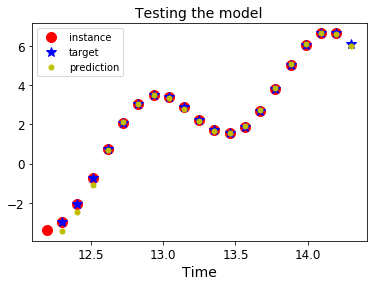

In [10]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "ro", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "b*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "y.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

We can see that the basic RNN has learnt the function and has a good fit. 

### Generate output

In [11]:
with tf.Session() as sess:                        
    saver.restore(sess, "./my_time_series_model")
    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


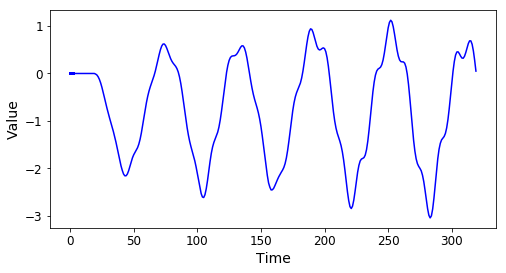

In [12]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

Unfortunitly the basic RNN has not learnt that the output is increasing in magnitude as time goes on. 

---
## Long Short-Term-Memory (LSTM) cells

There are two basic problems associated with the basic cells discussed above, and of course carefully avoided in the examples!

The first that in order to train the RNN on long sequences, it becomes, for training purposes, like a very deep neural network since the gradient of the cost function is back-propagated through the whole network. It therefore suffers from the same vanishing/exploding gradient problem of deep neural networks. Of course some of the same tricks used for deep neural networks can still be usefull. 

The second problem is that although part of the memory of the first inputs gradually fades away as more time steps are traversed. If the value that has to be predected only relies on the immediate past, this is not much of a problem. In many cases however, the context needed for an accurate prediction lies far in the past. For example, in the sentence 'There is a cloud in the ...', the immediate context makes it quite likely that the missing word is 'sky'. On the other hand, let's consider that statement, 'She lives in Mthatha. She speaks ...'. The immediate context indicates that the missing word is a language. Which language however, cannot be drived from the immediate past. That context is provided by the earlier statement. 

Fro this we need more complex cells, and one of the most popular is the LSTM (Long Short-Term Memory) cell of [Hochreiter and Schmidhuber](http://www.bioinf.jku.at/publications/older/2604.pdf).

---


# The LSTM cell

<figure> 
<figcaption></figcaption>
<img src="./images/lstm.png"
     width=300px
     alt="lstm"
     style="float: center"/> 
</figure>

The LSTM cell maintains two states, $\mathbf{c}_t$ and $\mathbf{h}_t$ in the Figure. The state at the top $\mathbf{c}_t$ is the cell state, and Olah call it a kind of conveyer belt. It carries information straight through the entire chain with only minor changes. Memory is removed by the forget **gate** and new memory is added by the input gate and the result is passed on. The gates determine which part of the information should pass through, and which part should be removed. The gates consist of a sigmoid neural layer, and a pointwise multiplication. Since the sigmoid layer outputs values between 0 and 1, the cell vector is multiplied by values between 0 and 1. A value of 1 ensures that that particular component of the state is perfectly preserved, while a value of zero completely removes that component from memory. 

In each LSTM cell there are 3 gates, a forget gate, an input gate, and an output gate. Let us look at these three gates in more detail.

---
### 1. Forget gate

The forget gate takes as input the short-term memory $\mathbf{h}_{t-1}$ and the input $\mathbf{x}_t$ and outputs,
$$
\mathbf{f}_t = \sigma(W_f[\mathbf{h}_{t-1},\mathbf{x}_t] + \mathbf{b}_f).
$$
This gate controls how much memory is destroyed.

### 2. Input gate

The input gate also takes as input the short-term memory $\mathbf{h}_{t-1}$ and the input $\mathbf{x}_t$ and outputs,
$$
\mathbf{i}_t = \sigma(W_i[\mathbf{h}_{t-1},\mathbf{x}_t] + \mathbf{b}_i),
$$
$$
\widetilde{\mathbf{c}}_t = \tanh(W_c[\mathbf{h}_{t-1},\mathbf{x}_t] + \mathbf{b}_c)
$$
This gate controls how much memory is added  at this time.

#### Update the long term memory or state

The long term memory is now updated by deleting part of its memory using the forget gate, and adding to its memory using the input gate,
$$
\mathbf{c}_t = \mathbf{f}_t*\mathbf{c}_{t-1} + \mathbf{i}_t*\widetilde{\mathbf{c}}_t.
$$


### 3. Output gate

Finally the output gate updates the short term memory, which is also the cell output. The input gate also takes as input the short-term memory $\mathbf{h}_{t-1}$ and the input $\mathbf{x}_t$ and outputs,
$$
\mathbf{o}_t = \sigma(W_o[\mathbf{h}_{t-1},\mathbf{x}_t] + \mathbf{b}_o),
$$
and
$$
\mathbf{h}_t = \mathbf{o}_{t}*\tanh(\mathbf{c}_t).
$$

### Construction
Now we construct a LSTM model using tf.contrib.rnn.BasicLSTMCell to create the cells, with 100 neurons, using relu activation functions. We are doing a regression style problem and for this we will make use of the MSE and ADAM to optimize, just as before. 

In [13]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

learning_rate = 0.001

with tf.name_scope("Inputs") :
    X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

with tf.name_scope("Cell"):
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.relu)
    lstm_outputs, states = tf.nn.dynamic_rnn(lstm_cell, X, dtype=tf.float32)

with tf.name_scope("Outputs"):
    stacked_lstm_outputs = tf.reshape(lstm_outputs, [-1, n_neurons])
    stacked_outputs = tf.layers.dense(stacked_lstm_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

with tf.name_scope("Training"):
    loss = tf.reduce_mean(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("Init_and_Saver"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

### Execution
Run for 1500 iterations, batch size 50

In [14]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Generate a test sequence
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    
    # Predict on the test sequence
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    saver.save(sess, "./my_lstm_time_series_model")

0 	MSE: 15.115627
100 	MSE: 1.4786355
200 	MSE: 0.5006361
300 	MSE: 0.30985782
400 	MSE: 0.118771255
500 	MSE: 0.06286281
600 	MSE: 0.04371503
700 	MSE: 0.04437162
800 	MSE: 0.043510098
900 	MSE: 0.052118573
1000 	MSE: 0.049101226
1100 	MSE: 0.038297866
1200 	MSE: 0.034967538
1300 	MSE: 0.0431967
1400 	MSE: 0.037618563


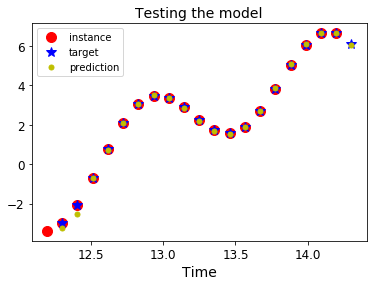

In [15]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "ro", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "b*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "y.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

We can see that the LSTM has learnt the function and has a good fit. 

In [16]:
with tf.Session() as sess:                        
    saver.restore(sess, "./my_lstm_time_series_model")
    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_lstm_time_series_model


#### Generate Output

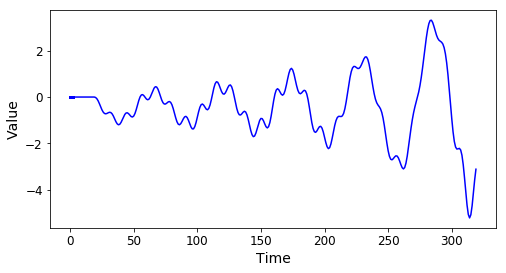

In [17]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

The LSTM cell has done better than the basic RNN as it has learnt that as time progresses, the magnitude increases. 

---
# The Gated Recurrent Unit (GRU)

<figure> 
<figcaption></figcaption>
<img src="./images/gru.png"
     width=300px
     alt="gru"
     style="float: center"/> 
</figure>

There are a number of variations of the LSTM cell and one of the most important is the GRU cell. It is a simplification of the LSTM cell and performs just as well, which explains its popularity. Its main features as compared with the LSTM cell, are

* There is a single state vector $\mathbf{h}_t$.
* A single controller controls both the forget gate and the input gate. If the controller outputs a 1, the input gate is open and the forget gate is closed. On the other hand, if is outputs a 0, the input gate is closed and the output gate is open. This means that if a memory is to be stored, it has to be erased first.
* There is no output gate as the full state vector is output at every step. There is a new controller that determines which part of the previous state is exposed to the main layer.

Looking at the mathematics will make this clear.

\begin{align}
\mathbf{z}_t &= \sigma(W_z[\mathbf{h}_{t-1},\mathbf{x}_t]),\\
\mathbf{r}_t &= \sigma(W_r[\mathbf{h}_{t-1},\mathbf{x}_t]),\\
\widetilde{\mathbf{h}}_t &= \tanh(W[\mathbf{r}_t*\mathbf{h}_{t-1},\mathbf{x}_t]),\\
    \mathbf{h}_t &= (1-\mathbf{z}_t)*\mathbf{h}_{t-1} + \mathbf{z}_t*\widetilde{\mathbf{h}}_{t}.
\end{align}





### Construction
Now we construct a GRU model using tf.contrib.rnn.GRUCell to create the cells, with 100 neurons, using relu activation functions. We are doing a regression style problem and for this we will make use of the MSE and ADAM to optimize, just as before. 

In [31]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

learning_rate = 0.001

with tf.name_scope("Inputs") :
    X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

with tf.name_scope("Cell"):
    gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.relu)
    gru_outputs, states = tf.nn.dynamic_rnn(gru_cell, X, dtype=tf.float32)

with tf.name_scope("Outputs"):
    stacked_gru_outputs = tf.reshape(gru_outputs, [-1, n_neurons])
    stacked_outputs = tf.layers.dense(stacked_gru_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

with tf.name_scope("Training"):
    loss = tf.reduce_mean(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("Init_and_Saver"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

### Execution
Run for 1500 iterations, batch size 50

In [32]:
n_iterations = 1600
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Generate a test sequence
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    
    # Predict on the test sequence
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    saver.save(sess, "./my_gru_time_series_model")

0 	MSE: 18.001982
100 	MSE: 1.236871
200 	MSE: 0.56422
300 	MSE: 0.38811332
400 	MSE: 0.20370233
500 	MSE: 0.10633521
600 	MSE: 0.059438452
700 	MSE: 0.053997226
800 	MSE: 0.04914086
900 	MSE: 0.059127163
1000 	MSE: 0.05402688
1100 	MSE: 0.040683806
1200 	MSE: 0.037607495
1300 	MSE: 0.047508392
1400 	MSE: 0.04392034
1500 	MSE: 0.053137667


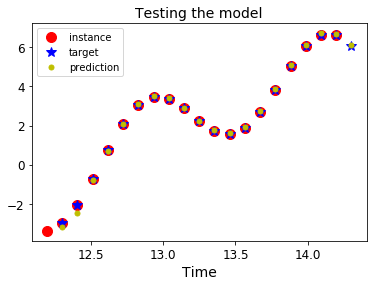

In [33]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "ro", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "b*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "y.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Again we can see that the GRU has a good fit. 

In [34]:
with tf.Session() as sess:                        
    saver.restore(sess, "./my_gru_time_series_model")
    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_gru_time_series_model


### Generate Output

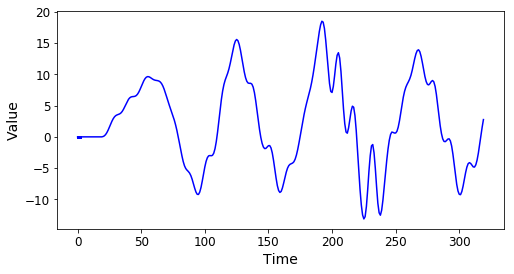

In [35]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

Here we see somethign interesting in that the output generated is not what we would expect. However the model is fitting the data rather well. 

---
# Additional Research

<figure> 
<figcaption></figcaption>
<img src="./images/dixon.png"
     width=400px
     alt="gru"
     style="float: center"/> 
</figure>


There is a great and short pressentation by Dr Matthew Dixon (you may remember him from the academic paper in Module 3). In his lecture titled "[The Neural Networks Survival Kit for Quants](https://www.youtube.com/watch?v=QOuwx8XLhO0&feature=youtu.be)" he attempts to debunk some of the common myths about Neural Networks. Slides to his presentation are found [here](http://mypages.iit.edu/~mdixon7/presentations/RavenPack_AI_Dixon.pdf). You can also find a copy in your notes.

This weeks paper in review is also by the same author, titled [Sequence Classification of the Limit Order Book using Recurrent Neural Networks](https://arxiv.org/pdf/1707.05642.pdf).  You can also find a copy in your notes. (We may ask questions from this)